# Индивидуальное задание (классификация)
Группа 45/2
Вариант 3
---

## Предсказать, согласится ли человек на открытие банковского депозита
Описание:
Необходимо построить модель классификации для прогнозирования, будет ли клиент подписываться на банковский депозит на основе различных факторов, представленных в датасете Bank Marketing.

**Импорт библиотек**

In [356]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

### 1. Загрузка и обзор данных.

Загрузка датасета и просмотр первых 5 строк;

In [357]:
file_path = 'bank-full.csv'
data = pd.read_csv(file_path, delimiter=';')

first_five_rows = data.head()
first_five_rows

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Просмотр общей информации о данных (количество строк, типы данных, наличие пропущенных значений и т.д.);

In [358]:
data_info = data.info()
data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Изучение статистики данных (среднее, стандартное отклонение, максимальное и минимальное значения);

In [359]:
data_description = data.describe()
data_description

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Изучение распределения целевой переменной (количество положительных и отрицательных классов).

In [360]:
target_distribution = data['y'].value_counts()
target_distribution

y
no     39922
yes     5289
Name: count, dtype: int64

### 2. Предварительная обработка данных

Обработка пропущенных значений (заполнение или удаление пропущенных данных);

In [361]:
# Проверка на пропущенные значения в каждом столбце
missing_values = data.isnull().sum()

missing_values

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Преобразовать категориальные признаки в числовые значения с помощью кодирования, например, с помощью метода One-Hot Encoding;

In [362]:
categorical_columns = data.select_dtypes(include=['object']).drop(['y'], axis=1).columns
numerical_columns = data.select_dtypes(include=['int64']).columns

categorical_transformer = OneHotEncoder(drop='first')

Масштабирование числовых переменных (нормализация или стандартизация) (например, с помощью метода StandardScaler)

In [363]:
numerical_transformer = StandardScaler()

# Составление пайплайна для предобработки
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Применение пайплайна к данным
X = data.drop('y', axis=1)
X_transformed = preprocessor.fit_transform(X)

# Вывод первых 5 преобразованных строк (в формате массива)
X_transformed[:5]

<5x42 sparse matrix of type '<class 'numpy.float64'>'
	with 70 stored elements in Compressed Sparse Row format>

### 3. Визуализация данных

Построение гистограмм для числовых переменных, чтобы изучить их распределение;

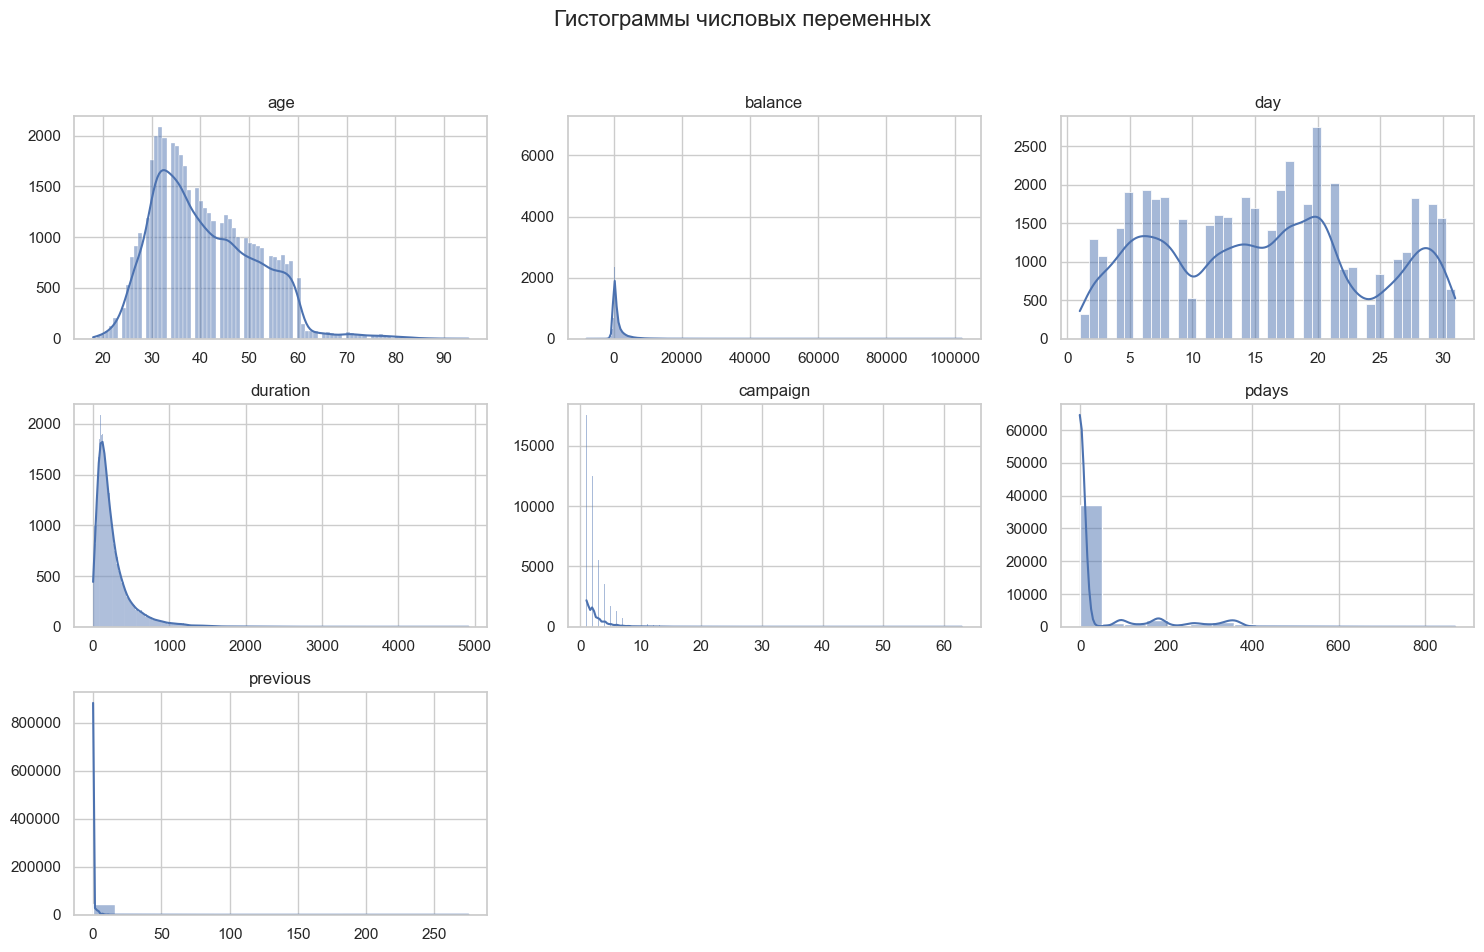

In [364]:
# Установка стиля для графиков
sns.set(style="whitegrid")

# Построение гистограмм для числовых переменных
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
fig.suptitle('Гистограммы числовых переменных', fontsize=16)
for i, col in enumerate(numerical_columns):
    ax = axes[i//3, i%3]
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Удаление пустых графиков
for i in range(len(numerical_columns), 3*3):
    fig.delaxes(axes[i//3, i%3])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Построение столбчатой диаграммы для категориальных переменных, чтобы изучить их распределение;

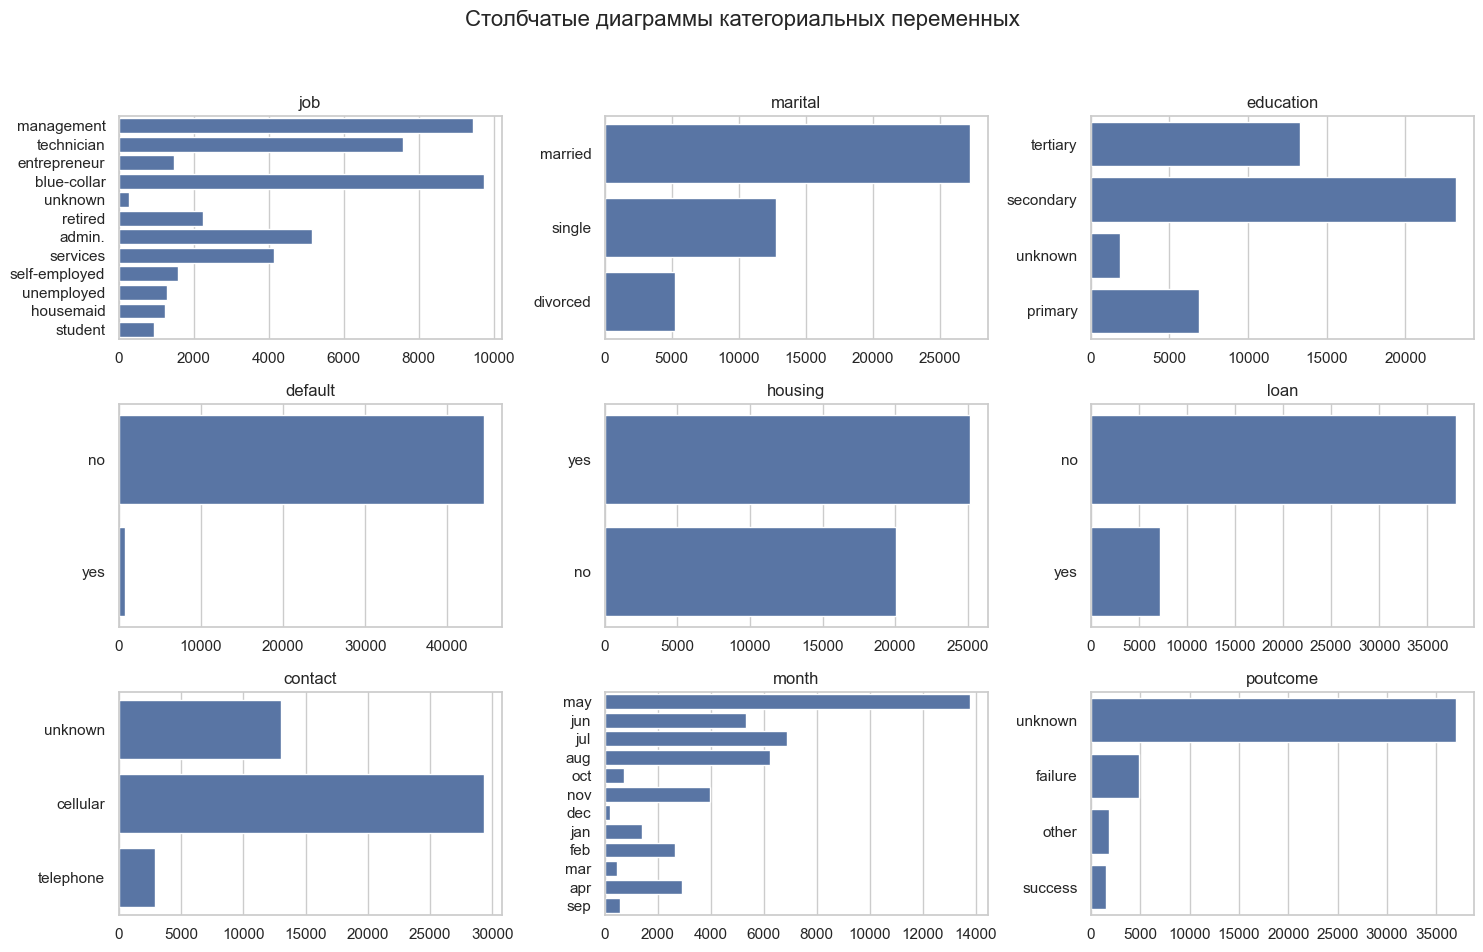

In [365]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
fig.suptitle('Столбчатые диаграммы категориальных переменных', fontsize=16)
for i, col in enumerate(categorical_columns):
    ax = axes[i//3, i%3]
    sns.countplot(y=col, data=data, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Удаление пустых графиков
for i in range(len(categorical_columns), 3*3):
    fig.delaxes(axes[i//3, i%3])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Построение матрицы корреляции, чтобы изучить взаимосвязь между переменными.

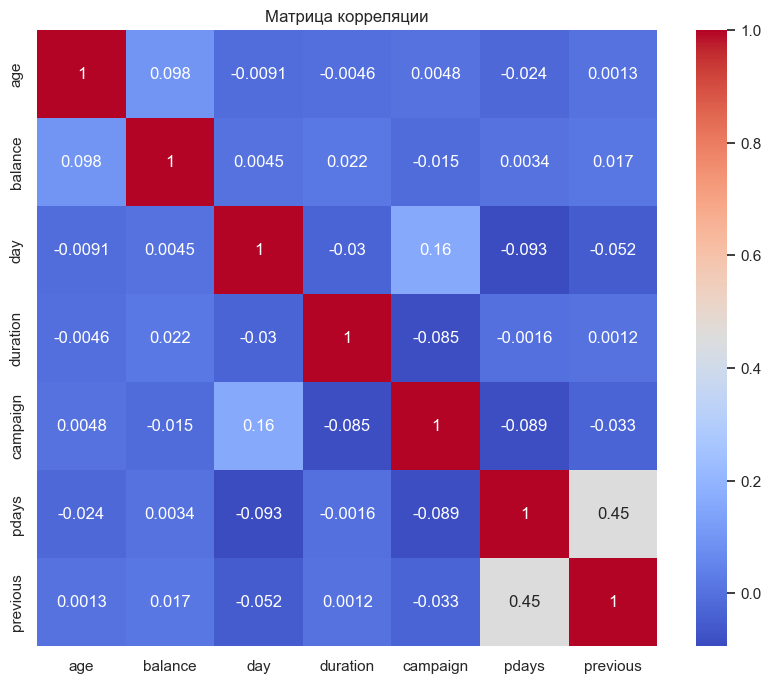

In [366]:
plt.figure(figsize=(10, 8))
correlation_matrix = data[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

### 4. Подготовка данных для моделирования

Разделение данных на обучающую и тестовую выборки;

In [367]:
# Преобразование целевой переменной в числовой формат
data['y'] = data['y'].map({'no': 0, 'yes': 1})

# Разделение данных на признаки и целевую переменную
X = data.drop('y', axis=1)
y = data['y']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Равномерное распределение классов в обучающей и тестовой выборках (применение методов для обработки несбалансированных данных).

In [368]:
# Сбалансирование классов в обучающей выборке
# Соединение X_train и y_train для удобства
train_data = pd.concat([X_train, y_train], axis=1)

# Разделение по классам
class_0 = train_data[train_data.y == 0]
class_1 = train_data[train_data.y == 1]

# Балансировка классов путем увеличения меньшего класса
class_1_upsampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)

# Объединение классов обратно
train_data_balanced = pd.concat([class_0, class_1_upsampled])

# Разделение сбалансированных данных обратно на признаки и целевую переменную
X_train_balanced = train_data_balanced.drop('y', axis=1)
y_train_balanced = train_data_balanced['y']

# Информация о распределении классов в обучающей выборке до и после балансировки
class_distribution_before = y_train.value_counts()
class_distribution_after = y_train_balanced.value_counts()

class_distribution_before, class_distribution_after

(y
 0    31970
 1     4198
 Name: count, dtype: int64,
 y
 0    31970
 1    31970
 Name: count, dtype: int64)

### 5. Построение модели классификации

Выбор подходящих алгоритмов машинного обучения для классификации (**логистическая регрессия**);

In [369]:
# Повторное применение предварительной обработки (One-Hot Encoding и StandardScaler)
X_transformed = preprocessor.fit_transform(X)

# Повторное разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Создание и обучение модели логистической регрессии
logreg_classifier = LogisticRegression(random_state=42, max_iter=1000)
logreg_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Обучение модели на обучающей выборке;

In [370]:
# Предсказание на тестовой выборке
y_pred_logreg = logreg_classifier.predict(X_test)

Оценка качества модели с использованием метрик (точность, полнота, F1-мера, ROC-кривая и т.д.);

In [371]:
# Оценка качества модели
classification_report_logreg = classification_report(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)

# Построение ROC-кривой
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_classifier.predict_proba(X_test)[:, 1])

classification_report_logreg

'              precision    recall  f1-score   support\n\n           0       0.92      0.98      0.94      7952\n           1       0.66      0.34      0.45      1091\n\n    accuracy                           0.90      9043\n   macro avg       0.79      0.66      0.70      9043\nweighted avg       0.88      0.90      0.88      9043\n'

In [372]:
roc_auc_logreg

0.6586201443306955

In [373]:
(fpr_logreg, tpr_logreg)

(array([0.        , 0.        , 0.        , ..., 0.93272133, 0.93272133,
        1.        ]),
 array([0.00000000e+00, 9.16590284e-04, 1.83318057e-03, ...,
        9.99083410e-01, 1.00000000e+00, 1.00000000e+00]))

1. Метрики качества модели:
    Точность (Precision):
    - Для класса 0 (отрицательный): 92%
    - Для класса 1 (положительный): 66%
    Полнота (Recall):
    - Для класса 0: 98%
    - Для класса 1: 34%
    F1-мера:
    - Для класса 0: 94%
    - Для класса 1: 45%
    Общая точность (Accuracy): 90%
2. ROC AUC Score: 0.6586
3. ROC-кривая: Представлена в виде массивов значений FPR (False Positive Rate) и TPR (True Positive Rate).

Подбор гиперпараметров модели для достижения лучшей производительности.

#### Общий Вывод
Модель логистической регрессии показывает хорошую общую точность (90%), но имеет существенные различия в точности и полноте для разных классов. В частности, модель лучше справляется с идентификацией класса 0, но её эффективность ниже при определении класса 1, что видно по более низким значениям полноты и F1-меры для этого класса.

Выбор подходящих алгоритмов машинного обучения для классификации (**cлучайный лес**);

In [374]:
# Создание и обучение модели случайного леса с ограничениями
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

Обучение модели на обучающей выборке;

In [375]:
# Предсказание на тестовой выборке
y_pred_rf = rf_classifier.predict(X_test)

Оценка качества модели с использованием метрик (точность, полнота, F1-мера, ROC-кривая и т.д.);

In [376]:
# Оценка качества модели
classification_report_rf = classification_report(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)

# Построение ROC-кривой
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_classifier.predict_proba(X_test)[:, 1])

classification_report_rf

'              precision    recall  f1-score   support\n\n           0       0.90      0.99      0.94      7952\n           1       0.74      0.19      0.30      1091\n\n    accuracy                           0.89      9043\n   macro avg       0.82      0.59      0.62      9043\nweighted avg       0.88      0.89      0.87      9043\n'

In [377]:
roc_auc_rf

0.5904028086945136

In [378]:
(fpr_rf, tpr_rf)

(array([0.        , 0.        , 0.        , ..., 0.99258048, 0.99283199,
        1.        ]),
 array([0.00000000e+00, 9.16590284e-04, 2.74977085e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]))

1. Метрики качества модели:
    Точность (Precision):
    - Для класса 0 (отрицательный): 90%
    - Для класса 1 (положительный): 74%
    Полнота (Recall):
    - Для класса 0: 99%
    - Для класса 1: 19%
    F1-мера:
    - Для класса 0: 94%
    - Для класса 1: 30%
    Общая точность (Accuracy): 89%
2. ROC AUC Score: 0.5904
3. ROC-кривая: Представлена в виде массивов значений FPR (False Positive Rate) и TPR (True Positive Rate).

Подбор гиперпараметров модели для достижения лучшей производительности.

#### Общий Вывод
Модель случайного леса с ограничениями показывает хорошую точность и высокую полноту для класса 0, но значительно ниже показатели для класса 1. Это может указывать на то, что модель склонна к предсказанию большинственного класса. ROC AUC Score 0.5904 свидетельствует о средней способности модели различать классы.

Выбор подходящих алгоритмов машинного обучения для классификации (**градиентный бустинг**);

In [379]:
# Создание и обучение модели градиентного бустинга
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

Обучение модели на обучающей выборке;

In [380]:
# Предсказание на тестовой выборке
y_pred_gb = gb_classifier.predict(X_test)

Оценка качества модели с использованием метрик (точность, полнота, F1-мера, ROC-кривая и т.д.);

In [381]:
# Оценка качества модели
classification_report_gb = classification_report(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_gb)

# Построение ROC-кривой
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_classifier.predict_proba(X_test)[:, 1])

classification_report_gb

'              precision    recall  f1-score   support\n\n           0       0.92      0.97      0.95      7952\n           1       0.66      0.42      0.51      1091\n\n    accuracy                           0.90      9043\n   macro avg       0.79      0.70      0.73      9043\nweighted avg       0.89      0.90      0.89      9043\n'

In [382]:
roc_auc_gb

0.6957252220933299

In [383]:
(fpr_gb, tpr_gb)

(array([0.        , 0.        , 0.        , ..., 0.99886821, 0.99962274,
        1.        ]),
 array([0.00000000e+00, 9.16590284e-04, 4.58295142e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]))

1. Метрики качества модели:
    Точность (Precision):
    - Для класса 0 (отрицательный): 92%
    - Для класса 1 (положительный): 66%
    Полнота (Recall):
    - Для класса 0: 97%
    - Для класса 1: 42%
    F1-мера:
    - Для класса 0: 95%
    - Для класса 1: 51%
    Общая точность (Accuracy): 90%
2. ROC AUC Score:  0.6957
3. ROC-кривая: Представлена в виде массивов значений FPR (False Positive Rate) и TPR (True Positive Rate).  

Подбор гиперпараметров модели для достижения лучшей производительности.

In [384]:
# Подбор гиперпараметров модели
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=22), param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

classification_report_gb

KeyboardInterrupt: 

In [ ]:
best_params

In [ ]:
best_score